In [ ]:
%pip install scikit-learn

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

class PurchaseOrderPredictor:
    _instance = None
    _is_initialized = False
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(PurchaseOrderPredictor, cls).__new__(cls)
        return cls._instance

    def __init__(self):
        if not PurchaseOrderPredictor._is_initialized:
            self.models = {}
            self.product_metrics = None
            self.last_training_date = None
            PurchaseOrderPredictor._is_initialized = True

    def train(self, purchase_orders: pd.DataFrame) -> None:
        """Train models once for all products"""
        df = purchase_orders.copy()
        df['DueDate'] = pd.to_datetime(df['DueDate'])
        df['Week'] = df['DueDate'].dt.isocalendar().week
        
        # Calculate weekly metrics
        self.product_metrics = df.groupby(['ProductID', 'Week']).agg({
            'OrderQty': ['mean', 'std', 'count'],
            'UnitPrice': 'mean'
        }).reset_index()
        
        # Train model for each product
        for product_id in df['ProductID'].unique():
            product_data = self.product_metrics[self.product_metrics['ProductID'] == product_id]
            
            if len(product_data) < 4:  # Minimum weeks of data required
                continue
                
            X = product_data[['Week']]
            y = product_data['OrderQty']['mean']
            
            model = RandomForestRegressor(n_estimators=100)
            model.fit(X, y)
            self.models[product_id] = model
            
        self.last_training_date = datetime.now()

    def predict_top_products(self, target_date: datetime, top_n: int = 5) -> pd.DataFrame:
        """Predict top products for given week"""
        if not self.models:
            raise ValueError("Model not trained. Call train() first.")
            
        target_week = target_date.isocalendar().week
        predictions = []
        
        for product_id, model in self.models.items():
            product_data = self.product_metrics[self.product_metrics['ProductID'] == product_id]
            pred_qty = model.predict([[target_week]])[0]
            confidence = model.score(product_data[['Week']], product_data['OrderQty']['mean'])
            
            # Calculate trend using recent weeks
            recent_data = product_data.tail(12)
            trend = np.polyfit(range(len(recent_data)), recent_data['OrderQty']['mean'], 1)[0]
            
            predictions.append({
                'ProductID': product_id,
                'PredictedQty': round(pred_qty),
                'Confidence': confidence,
                'WeeklyTrend': trend
            })
        
        predictions_df = pd.DataFrame(predictions)
        predictions_df['Score'] = predictions_df['Confidence'] * (1 + predictions_df['WeeklyTrend'])
        return predictions_df.nlargest(top_n, 'Score')

    def visualize_predictions(self, predictions: pd.DataFrame) -> None:
        """Visualize top predictions"""
        plt.figure(figsize=(12, 6))
        sns.barplot(data=predictions, x='ProductID', y='PredictedQty')
        plt.title('Top Product Predictions by Week')
        plt.xticks(rotation=45)
        plt.show()


# Example usage
predictor = PurchaseOrderPredictor()
purchase_orders = pd.read_csv('data/purchaseOrderDetail.csv')

# Train once
predictor.train(purchase_orders)

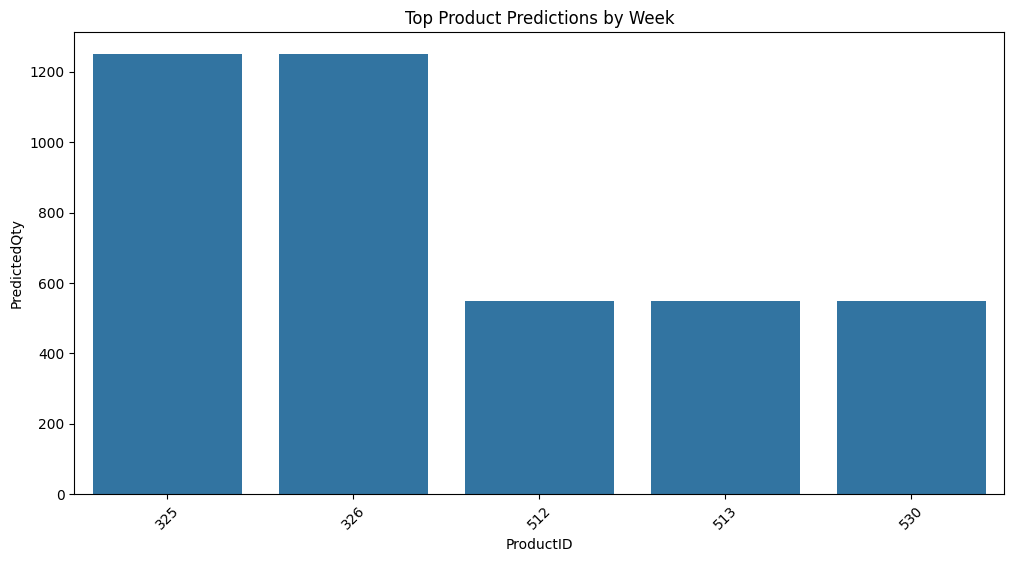

In [24]:
target_date = pd.Timestamp('2024-06-01')
predictions = predictor.predict_top_products(target_date)
predictor.visualize_predictions(predictions)